<a href="https://colab.research.google.com/github/Laurahg22/Trabajo-analitica-RH/blob/main/d_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe de librerías

In [1]:
#### Cargar paquetes siempre al inicio
import pandas as pd ### para manejo de datos
import sqlite3 as sql #### para bases de datos sql
import sys ## saber ruta de la que carga paquetes

In [2]:
## Conectar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
###Ruta directorio qué tiene paquetes
sys.path
sys.path.append('/content/drive/MyDrive/Trabajo-analitica-RH') ## este comanda agrega una ruta

In [4]:
import a_funciones as funciones  ###archivo de funciones propias

In [5]:
import pandas as pd ### para manejo de datos
import sqlite3 as sql

from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import numpy as np
import matplotlib.pyplot as plt ### gráficos
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables
import openpyxl

#Árbol de decisión

In [6]:
# Leer el df df2015

df2015 = pd.read_csv('/content/drive/MyDrive/Trabajo-analitica-RH/data/df2015.csv')
df2015

,Age,DistanceFromHome,Education,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51,6,2,0,1,131160,1.0,11,0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,31,10,1,0,1,41890,0.0,23,1,6.0,...,0,0,0,0,1,0,0,0,0,1
2,32,17,4,1,4,193280,1.0,15,3,5.0,...,0,0,0,0,0,1,0,0,1,0
3,38,2,5,1,3,83210,3.0,11,3,13.0,...,0,0,0,0,0,0,0,0,1,0
4,32,10,1,1,1,23420,4.0,12,2,9.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,5,4,0,1,60290,3.0,17,1,10.0,...,0,0,0,0,1,0,0,0,0,1
4406,29,2,4,1,1,26790,2.0,15,0,10.0,...,1,0,0,0,0,0,0,1,0,0
4407,25,25,2,1,2,37020,0.0,20,0,5.0,...,0,0,0,0,0,1,0,0,1,0
4408,42,18,2,1,1,23980,0.0,14,1,10.0,...,1,0,0,0,0,0,0,1,0,0


In [7]:
######## con base en los modelos candidatos se realizará una selección de variables ########

y = df2015['Attrition']
X1 = df2015.loc[:, ~df2015.columns.isin(df2015['Attrition'])]
scaler=StandardScaler()
scaler.fit(X1)
X2=scaler.transform(X1)
X=pd.DataFrame(X2,columns=X1.columns)

|--- TotalWorkingYears <= 1.50
|   |--- MonthlyIncome <= 112610.00
|   |   |--- Age <= 26.50
|   |   |   |--- class: 1
|   |   |--- Age >  26.50
|   |   |   |--- class: 0
|   |--- MonthlyIncome >  112610.00
|   |   |--- WorkLifeBalance <= 3.50
|   |   |   |--- class: 0
|   |   |--- WorkLifeBalance >  3.50
|   |   |   |--- class: 1
|--- TotalWorkingYears >  1.50
|   |--- MaritalStatus_Single <= 0.50
|   |   |--- NumCompaniesWorked <= 4.50
|   |   |   |--- class: 0
|   |   |--- NumCompaniesWorked >  4.50
|   |   |   |--- class: 0
|   |--- MaritalStatus_Single >  0.50
|   |   |--- Age <= 33.50
|   |   |   |--- class: 0
|   |   |--- Age >  33.50
|   |   |   |--- class: 0



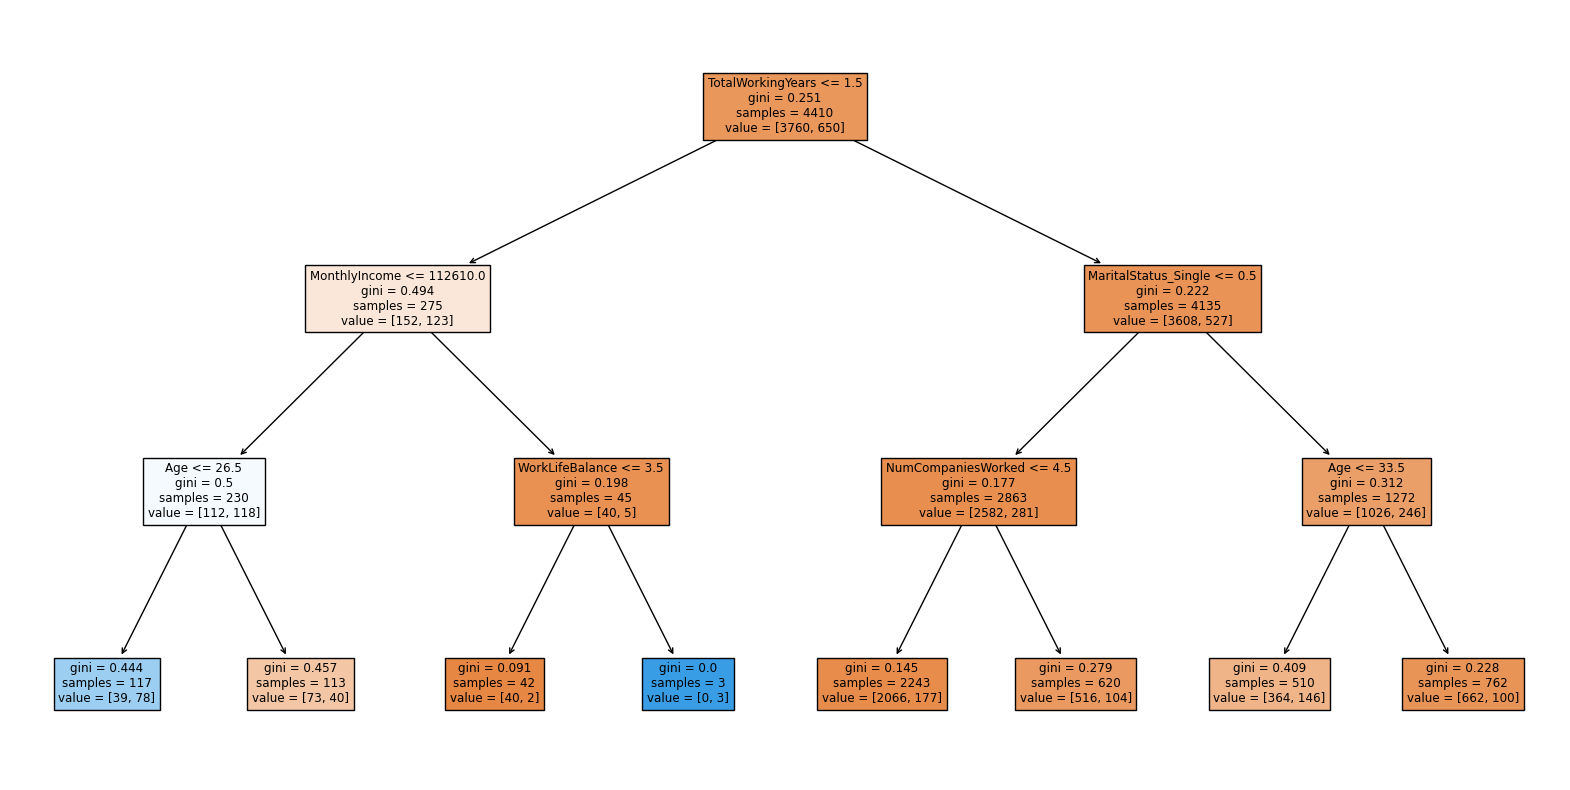

In [8]:
# Crear y entrenar el modelo de árbol de decisión
rtree = DecisionTreeClassifier(max_depth=3)
rtree.fit(X=df2015.drop('Attrition', axis=1), y=df2015['Attrition'])

# Generar una representación de texto del árbol de decisión
tree_text = export_text(rtree, feature_names=df2015.drop('Attrition', axis=1).columns.tolist())
print(tree_text)

# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(rtree, feature_names=df2015.drop('Attrition', axis=1).columns.tolist(), filled=True)
plt.show()

#Selección de variables

In [11]:
y = df2015['Attrition']
X1 = df2015.loc[:, ~df2015.columns.isin(['EmployeeID'])]
X2 = scaler.transform(X1)

# Excluye 'Attrition' de las características
X_features = X1.drop(labels=['Attrition'], axis=1)

# Crea el DataFrame X con las características escaladas y sin la variable 'Attrition'
X_features = X1.drop(columns=['Attrition'])

# Define los modelos seleccionados
m_logreg = LogisticRegression()
m_tree = DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

# Lista de modelos seleccionados
modelos = [m_logreg, m_tree, m_rf, m_gbt]

# Ahora, utiliza estos modelos en tu función de selección de variables
var_names = funciones.sel_variables(modelos, X_features, y, threshold="2*mean")

In [12]:
var_names.shape

(13,)

In [13]:
var_names

array(['Age', 'BusinessTravel_Travel_Frequently', 'DistanceFromHome',
       'EnvironmentSatisfaction', 'JobSatisfaction',
       'MaritalStatus_Single', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsWithCurrManager'], dtype=object)